# The impact of ambient noise and model selection for sleep classification

1. Overview of setup for scoring based only on movement
    1. Input is accelerometer
    2. Then some preprocessing. Either actigraphy or specgram, or other.
    3. ML model => probabilities of being asleep, or WLDM probability.
2. Issue of noise. Dig up some old pics, or just post side-by-sides for same timestamps, same subject.
3. Explain the models.
    1. Classic Log Reg, interp as single layer CNN 1d
    2. MO UNet, defer to publication.
    3. SmartMap, Naive


## The pipeline from movement to awake-asleep classification

Most, if not all, methods of automatic sleep scoring in use today is based on triaxial accelerometer data. This applies to both clinical sleep tracking and smart devices in tech. These data record the acceleration in the x-, y-, and z-axis of a smart watch or phone, measured in units of the Earth's gravity _g_ = 9.8 m/s^2; typically, sampling is at 50 or 100 Hz.

We'll use the Pisces library to analyze ...

In [1]:
# Let's load some accelerometer data and plot it
from pisces.data_sets import DataSetObject

import os
from pathlib import Path

CWD = Path(os.getcwd())
# hardcoded data locations are easiest, if most brittle
data_location = CWD.parent.parent.joinpath('data_sets')
print("Looking for data in ", data_location)

# This assumes you have set up the walch_et_al data set. See [this notebook]() for how to do that.
sets = DataSetObject.find_data_sets(data_location)
walch = sets['walch_et_al']
walch.parse_data_sets()
print(f"Found {len(walch.ids)} subjects")

Looking for data in  /Users/eric/Engineering/Work/pisces/data_sets
Found 31 subjects


In [7]:
walch_0 = walch.ids[0]

w0_accel = walch.get_feature_data( 'accelerometer', walch_0,).to_numpy()

In [8]:
w0_accel.shape

(1187903, 4)

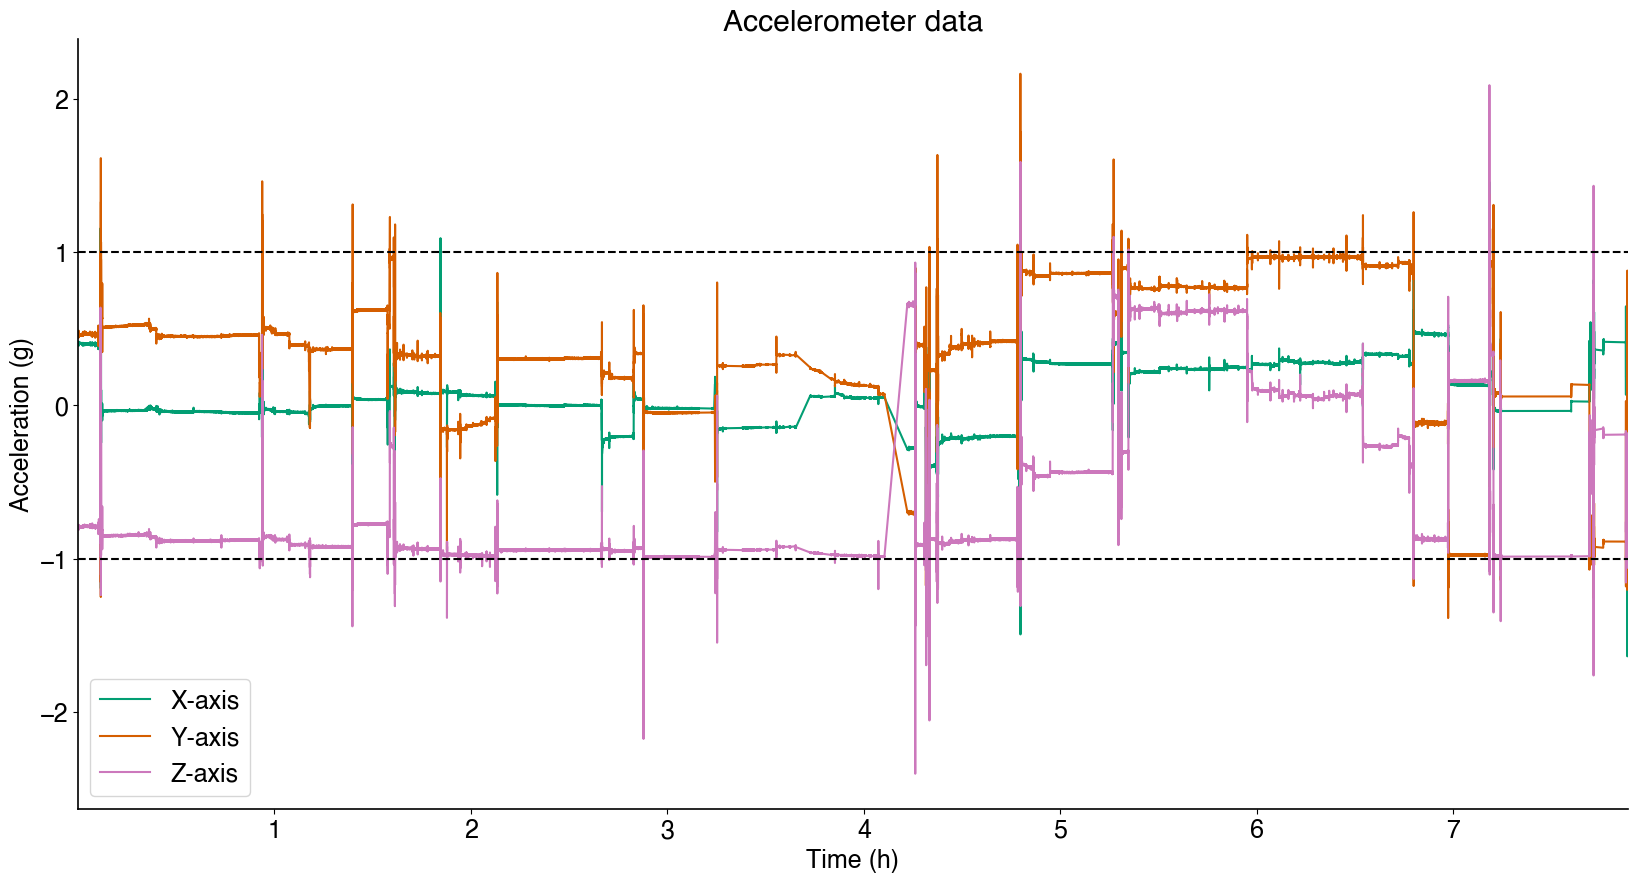

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

PALETTE = sns.color_palette('colorblind')
# Setting font and style parameters
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 18

def set_plot_style(ax):
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Customize the remaining spines (left and bottom)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)

def plot_accel_data(ax, w0_accel):
    axis_names = ['Time (h)', 'X-axis', 'Y-axis', 'Z-axis']

    w0_accel[:, 0] /= 3600

    for i in range(1, 4):
        ax.plot(w0_accel[:, 0], w0_accel[:, i], label=axis_names[i], color=PALETTE[i+1])

    # draw horizontal -- lines at +/- 1g
    ax.axhline(1, color='black', linestyle='--')
    ax.axhline(-1, color='black', linestyle='--')

    ax.set_xlim(w0_accel[0, 0], w0_accel[-1, 0])
    ax.set_title("Accelerometer data")
    ax.set_xlabel(axis_names[0])
    ax.set_ylabel("Acceleration (g)")
    ax.legend()
    set_plot_style(ax)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plot_accel_data(ax, w0_accel)

In [ ]:
from matplotlib import pyplot as plt



def hybrid_overlay(ax, h0_accel, w0_accel):
    axis_names = ['Time (h)', 'X-axis', 'Y-axis', 'Z-axis']
    w0_time = w0_accel[:, 0]
    w0_time /= 3600
    h0_time = h0_accel[:, 0]
    h0_time /= 3600

    for i in range(1, 4):
        ax.plot(h0_accel[:, 0], h0_accel[:, i], label=axis_names[i], color=PALETTE[i+1])
        ax.plot(w0_accel[:, 0], w0_accel[:, i], c='black', alpha=0.8)

    # draw horizontal -- lines at +/- 1g
    ax.axhline(1, color='black', linestyle='--')
    ax.axhline(-1, color='black', linestyle='--')

    ax.set_xlim(h0_accel[0, 0], h0_accel[-1, 0])
    ax.set_title("Noisy 'Hybrid' Accelerometer data")
    ax.set_xlabel(axis_names[0])
    ax.set_ylabel("Acceleration (g)")
    ax.legend()
    set_plot_style(ax)


For clinical sleep tracking, the standard has long been Cole-Kripke like methods based on highly filtered and aggregated _actigraphy_ data. The specifics of the filtering and aggregation were proprietary until a few years ago (e.g. ActiGraph algorithm on GitHub) though it is possible to reverse-engineer these algorithms on specific data sets (e.g. te Lindert, _et al_). Once processed, a weighted sum of this data in a sliding window is taken, with weights determined by gradient descent methods.

Pisces has Arcascope's ADS processing, which is more robust to noise (more on this later). It also has _te Lindert et al_'s reverse-engineering, and is compatible with the `ag_counts` except for the python version restriction to <3.10 (hence the library is not integrated here).

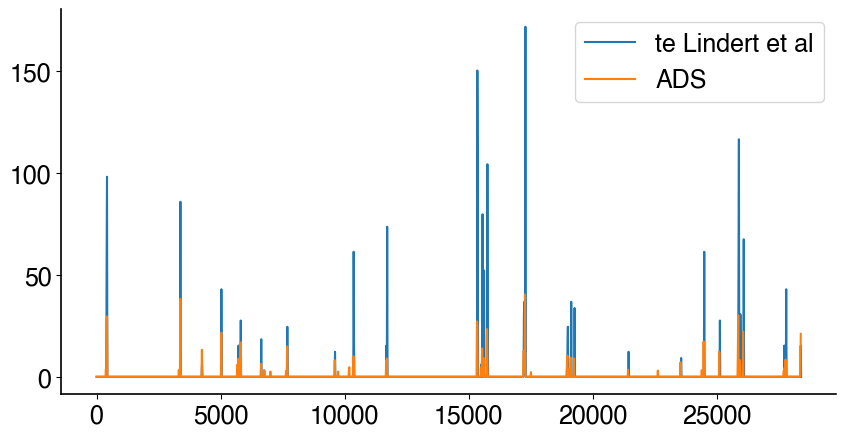

In [ ]:
from pisces.utils import build_ADS, build_activity_counts_te_Lindert_et_al

# Let's build some activity counts

# Arcascope's noise-robust activity detection system
w0_ads = build_ADS(w0_accel) 
# te Lindert et al's activity detection system
# There are filters that calibrate on the inputs, hence added noise leads to filtering of information
w0_tL = build_activity_counts_te_Lindert_et_al(w0_accel) 


fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(w0_tL[0], w0_tL[1], label='te Lindert et al')
ax.plot(w0_ads[0], w0_ads[1], label='ADS')
ax.legend()
set_plot_style(ax)

The field of automatic scoring in consumer tech smart watches has clustered around more sophisticated techniques utilizing the high-resolution and high fidelity of consumer accelerometers. One well-known approach is to take a spectrogram, or power-spectrum decomposition, of this data. See, e.g., (Canton & Walch GitHub), Mads Olsen, ...

Spectrograms are processed by deep neural networks akin to image segmenters, which instead of outputting _a cat is over here_ or _a dump truck is here_ identifies _this segment looks like someone in REM sleep_, etc.

Text(0.5, 1.0, 'Spectrogram of Accelerometer Data')

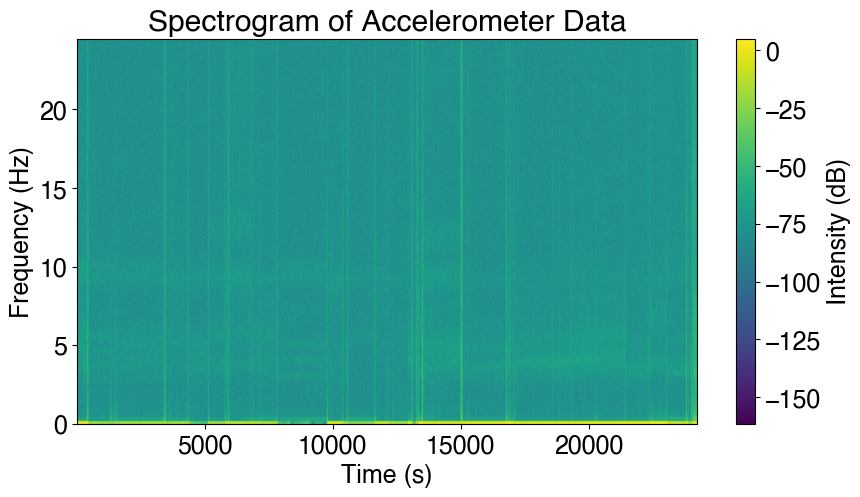

In [ ]:
# We provide an example of a spectrogram. 
# Specific ML models will have their own configurations of NFFT, pre-transform resampling, etc.

import numpy as np


w0_time = w0_accel[:, 0]
w0_accel_x = w0_accel[:, 1]
w0_accel_y = w0_accel[:, 2]
w0_accel_z = w0_accel[:, 3]

# Compute the median sampling rate
median_Hz = int(1 / np.median(np.diff(w0_time)))
nfft = 512
overlap = nfft // 2


# Compute the spectrogram for each axis
plt.figure(figsize=(10, 5))
spec, _, _, _ = plt.specgram(w0_accel_x, NFFT=nfft, Fs=median_Hz, noverlap=overlap, cmap='viridis')
plt.colorbar(label='Intensity (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram of Accelerometer Data')

## The challenge of Noise

In [13]:

hybrid = sets['hybrid_motion']
hybrid.parse_data_sets()
print(f"Found {len(hybrid.ids)} subjects")
hybrid_0 = walch_0  # same data set ids, accelerometer data has just been modified

h0_accel = hybrid.get_feature_data( 'accelerometer', hybrid_0,).to_numpy()

Found 31 subjects


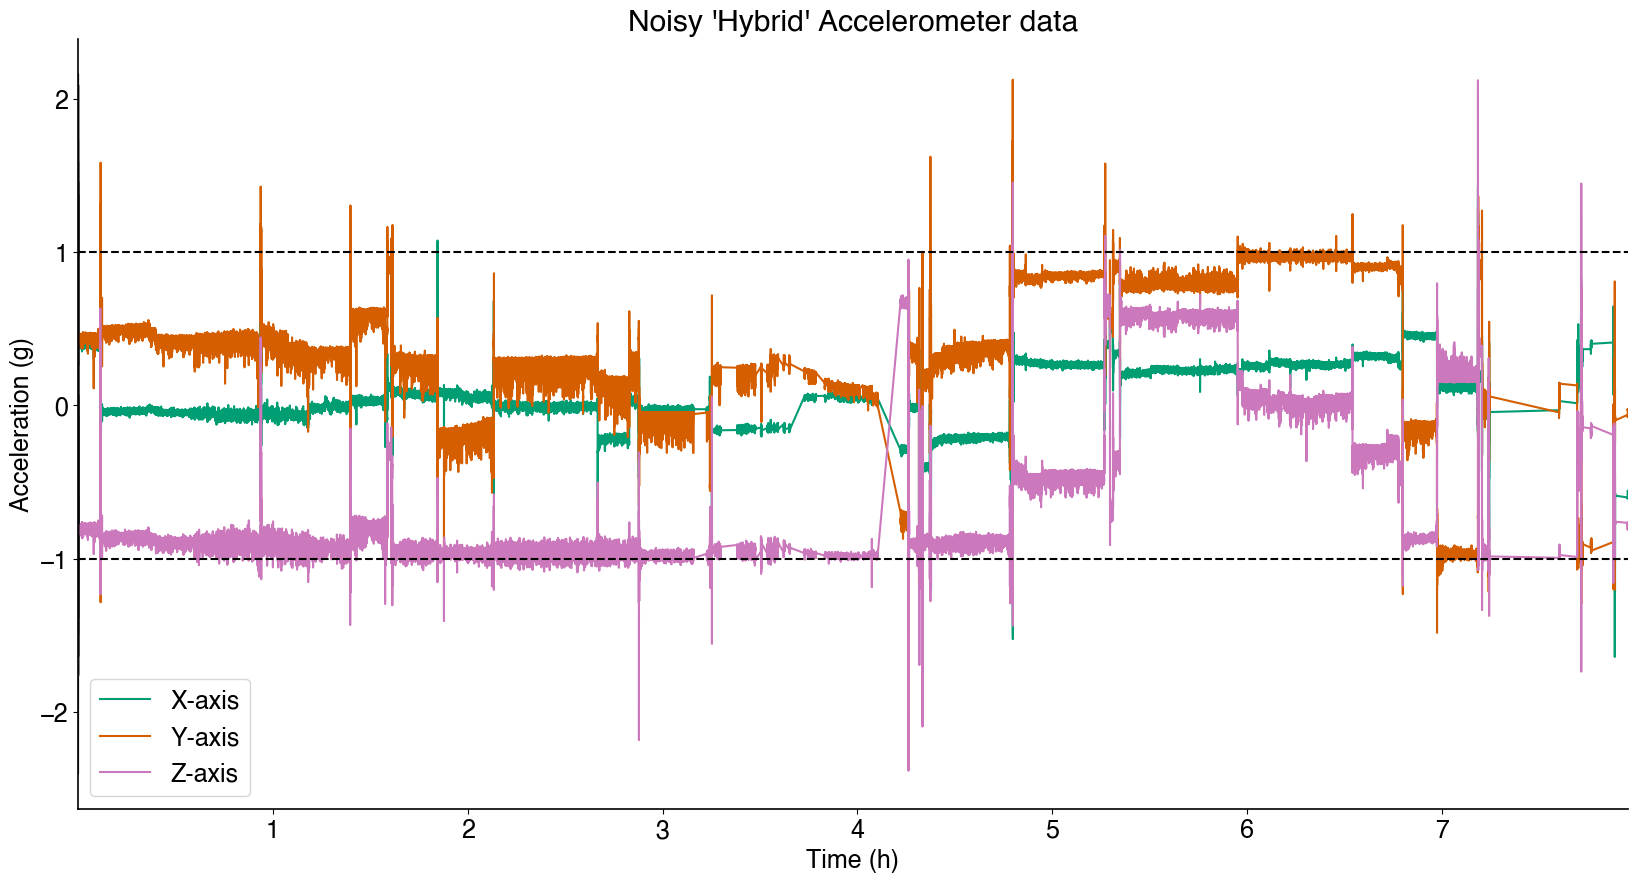

In [14]:

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
hybrid_overlay(ax, h0_accel, w0_accel)


# ROC Explainer

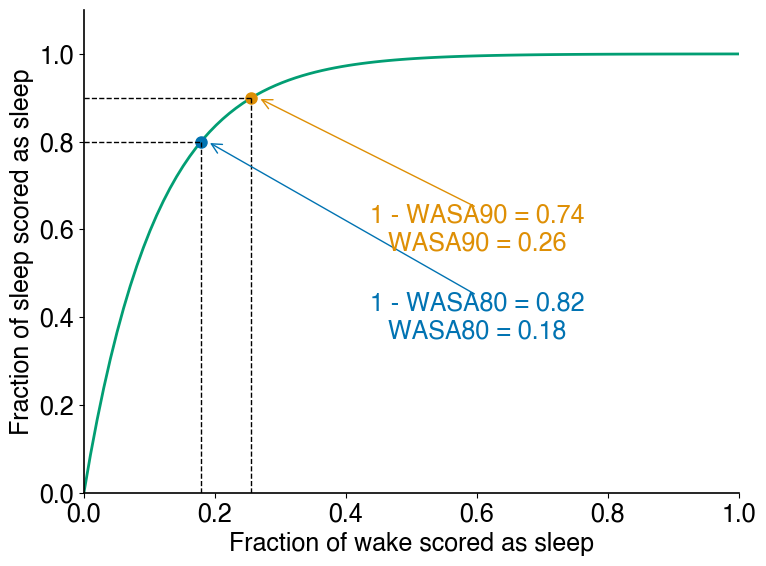

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def roc_explainer(ax):
    # Color palette
    color_palette = sns.color_palette("colorblind")

    # Data for the curve
    DECAY = 9
    def roc_map(x):
        return 1 - np.exp(-x * DECAY)
    def roc_inv_map(y):
        return -np.log(1 - y) / DECAY 
    x = np.linspace(0, 1, 100)
    y = roc_map(x)

    # WASA80 and WASA90 points
    ps_to_check = [0.8, 0.9]
    wasa80_y = 0.8
    wasa80_x = roc_inv_map(wasa80_y)
    wasa90_y = 0.9
    wasa90_x = roc_inv_map(wasa90_y)

    # Plotting
    # fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(x, y, color=color_palette[2], linewidth=2)

    # Adding points for WASA80 and WASA90
    ax.plot(wasa80_x, wasa80_y, 'o', color=color_palette[0], markersize=8, label="WASA80")
    ax.plot(wasa90_x, wasa90_y, 'o', color=color_palette[1], markersize=8, label="WASA90")

    # Adding dashed lines for visual reference
    ax.hlines(wasa80_y, 0, wasa80_x, color='black', linestyle='--', linewidth=1)
    ax.vlines(wasa80_x, 0, wasa80_y, color='black', linestyle='--', linewidth=1)
    ax.hlines(wasa90_y, 0, wasa90_x, color='black', linestyle='--', linewidth=1)
    ax.vlines(wasa90_x, 0, wasa90_y, color='black', linestyle='--', linewidth=1)

    # Annotations for the WASA points using f-strings and aligned vertically at x=0.6
    text_x = 0.6  # Fixed x position for annotations
    text_wasa80_y = 0.4  # Custom y position for WASA80 annotation
    text_wasa90_y = text_wasa80_y + 0.2 # Custom y position for WASA90 annotation
    arrow_offset_y = 0.05
    arrow_offset_x = 0.01

    # Adding WASA80 annotation with an arrow
    ax.text(
        text_x, text_wasa80_y,
        f"1 - WASA80 = {1 - wasa80_x:.2f}\nWASA80 = {wasa80_x:.2f}", 
        color=color_palette[0], ha='center', va='center'
    )
    ax.annotate(
        '', xy=(wasa80_x + arrow_offset_x, wasa80_y), xytext=(text_x, text_wasa80_y + arrow_offset_y),
        arrowprops=dict(arrowstyle="->", color=color_palette[0])
    )

    # Adding WASA90 annotation with an arrow
    ax.text(
        text_x, text_wasa90_y,
        f"1 - WASA90 = {1 - wasa90_x:.2f}\nWASA90 = {wasa90_x:.2f}", 
        color=color_palette[1], ha='center', va='center'
    )
    ax.annotate(
        '', xy=(wasa90_x + arrow_offset_x, wasa90_y), xytext=(text_x, text_wasa90_y + arrow_offset_y),
        arrowprops=dict(arrowstyle="->", color=color_palette[1])
    )

    # Axis labels
    ax.set_xlabel("Fraction of wake scored as sleep")
    ax.set_ylabel("Fraction of sleep scored as sleep")


    # Set limits
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.1)

    set_plot_style(ax)

_, ax = plt.subplots(figsize=(8, 6))
roc_explainer(ax)
# Show plot
plt.tight_layout()
plt.show()


# Putting it all together

Now we combine these into Figure 1 from our paper.

/var/folders/h4/pg7xmblx74zbp2yhls4bc_mh0000gn/T/ipykernel_65149/3659579592.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


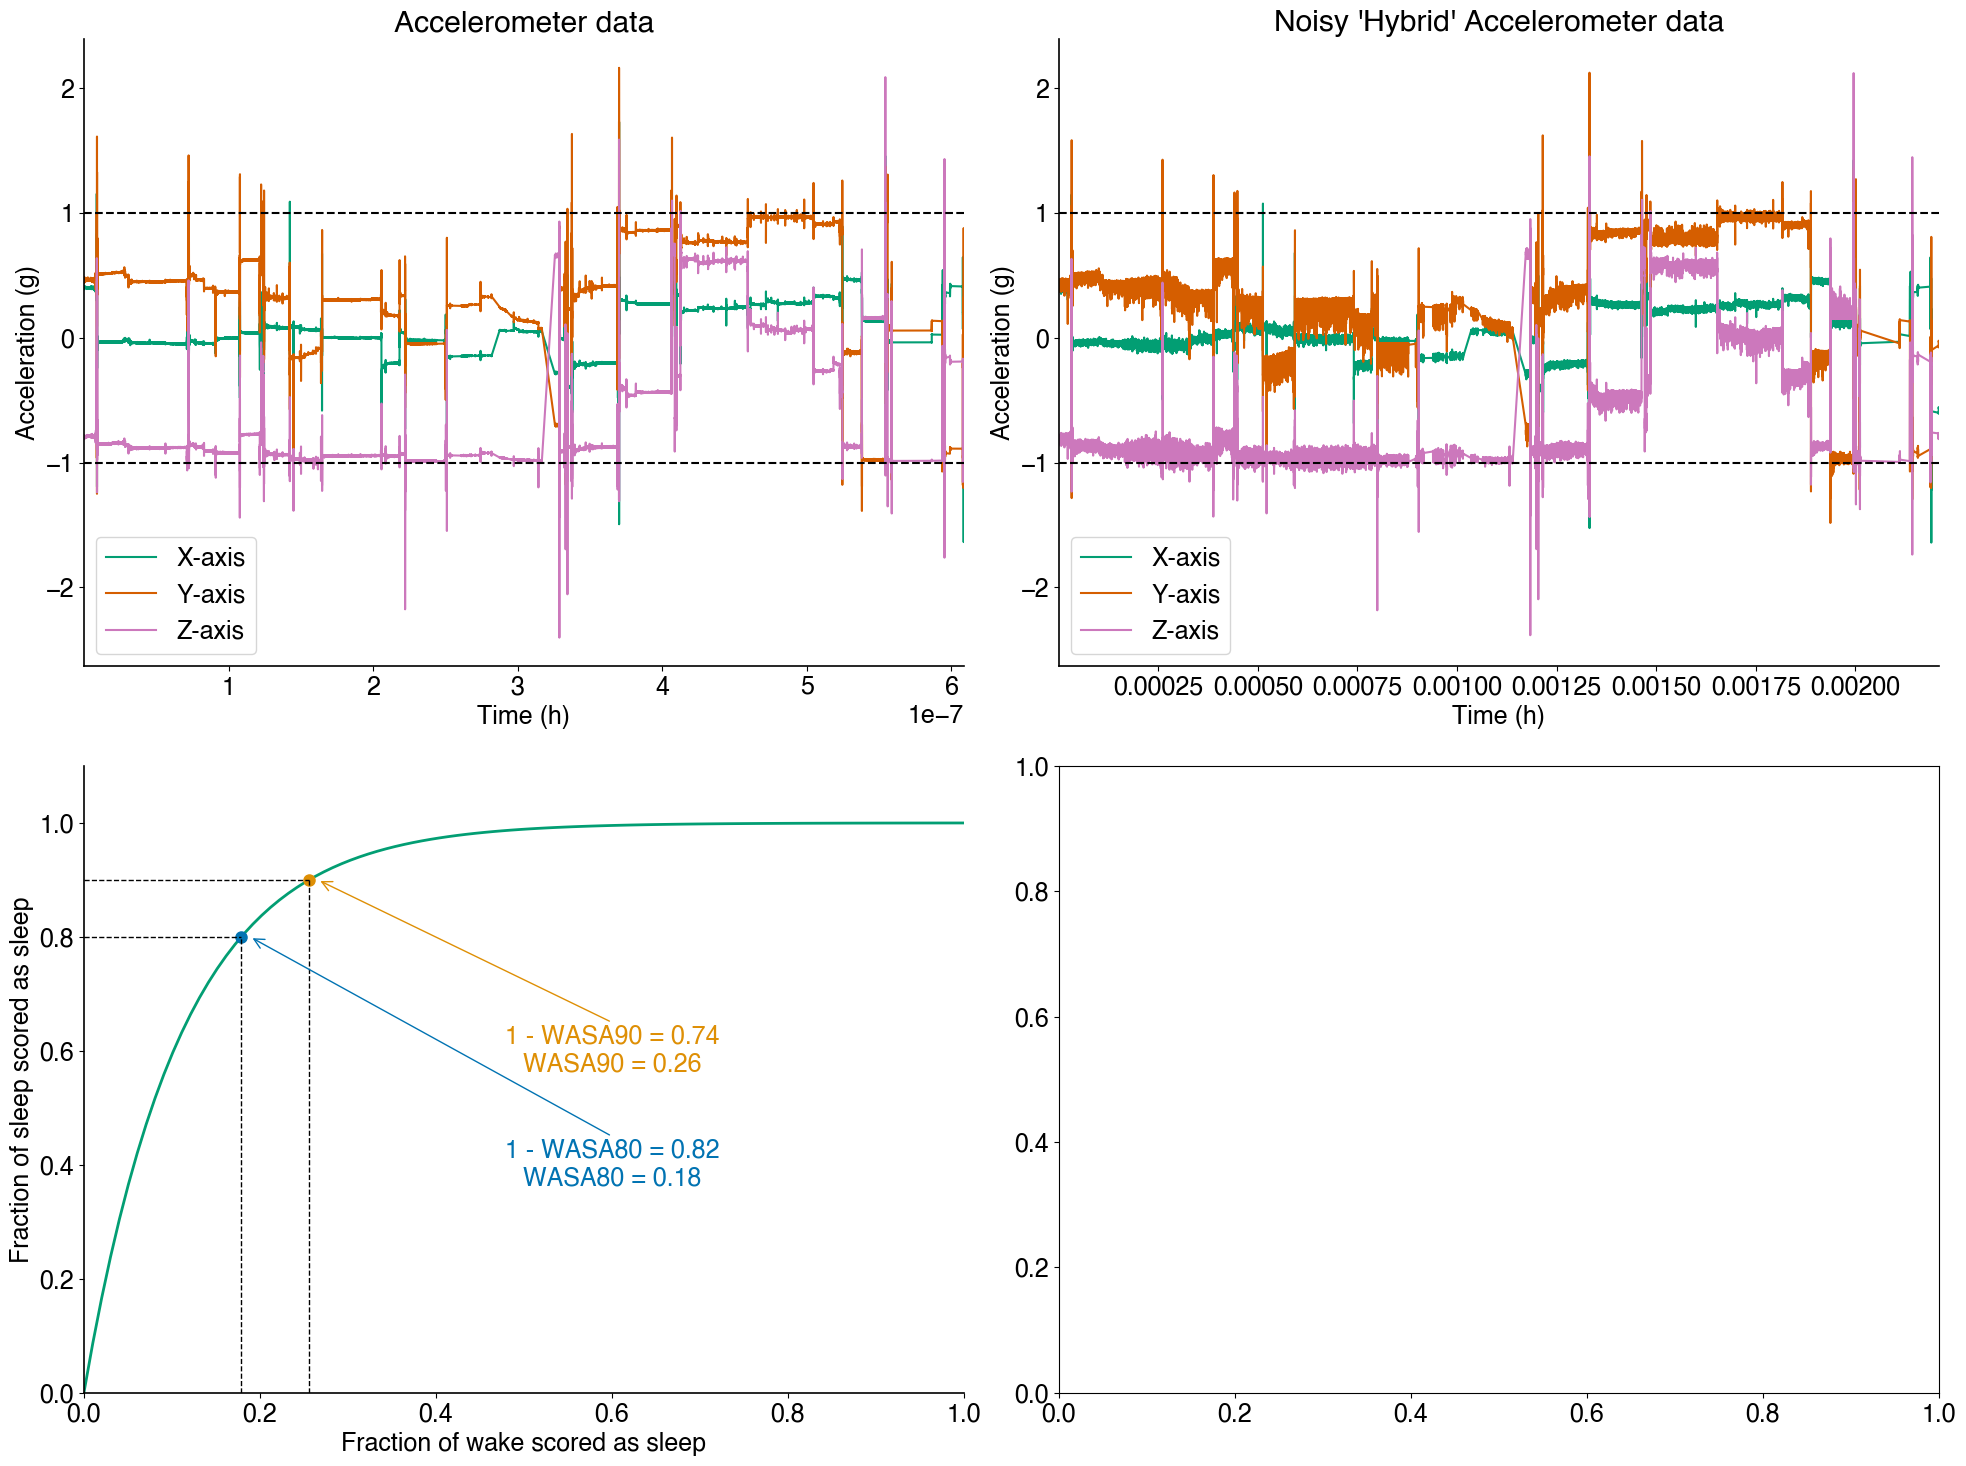

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

# Plot the accelerometer data
plot_accel_data(axs[0, 0], w0_accel)
hybrid_overlay(axs[0, 1], h0_accel, w0_accel)

# Plot the ROC explainer
roc_explainer(axs[1, 0])

fig.tight_layout()

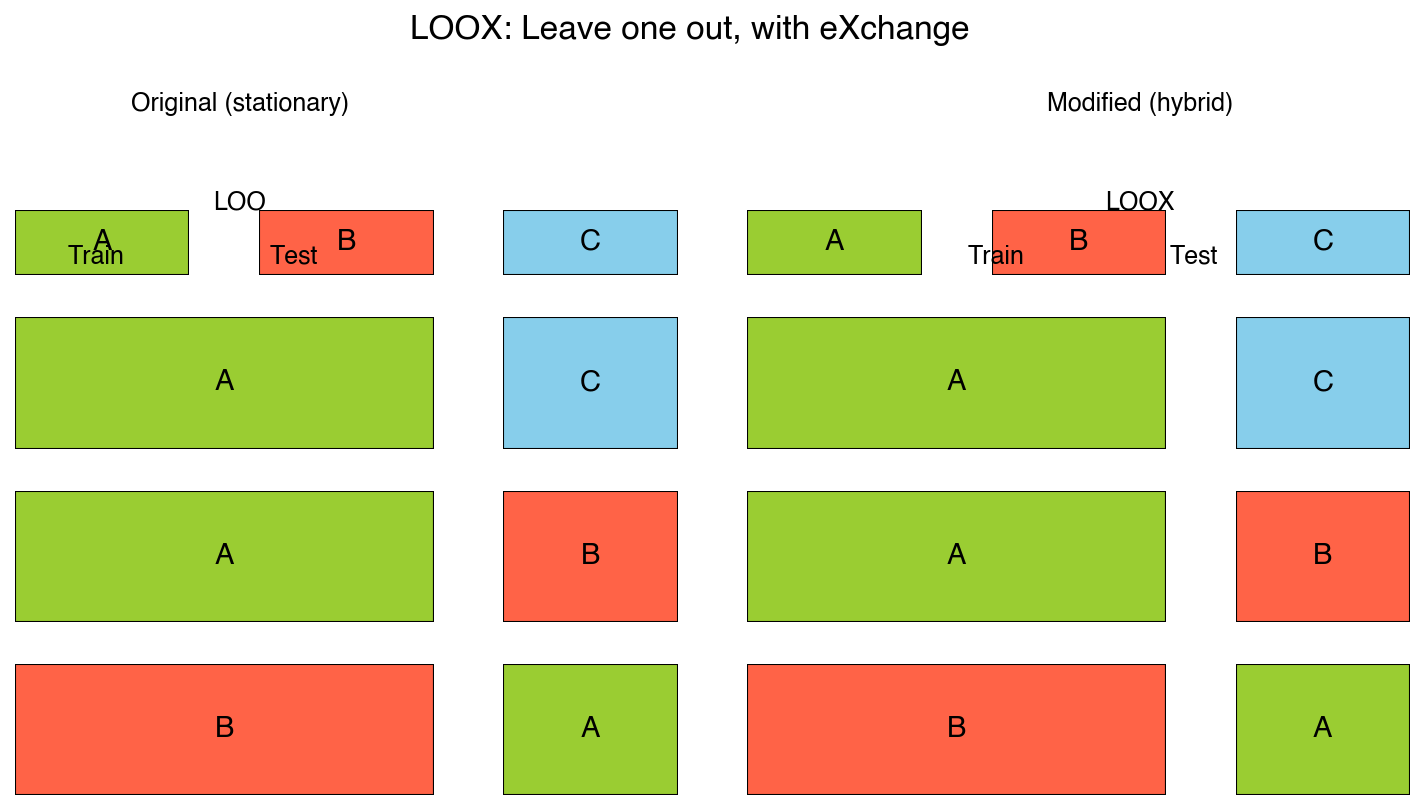

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

# Colors for blocks
colors = {'A': 'yellowgreen', 'B': 'tomato', 'C': 'skyblue'}

# Initialize the figure
fig = plt.figure(figsize=(12, 6), dpi=150)
gs = GridSpec(5, 6, figure=fig, height_ratios=[0.5, 0.5, 1, 1, 1])

# Title texts
fig.text(0.5, 0.95, "LOOX: Leave one out, with eXchange", ha='center', fontsize=16, fontweight='bold')
fig.text(0.25, 0.87, "Original (stationary)", ha='center', fontsize=12)
fig.text(0.75, 0.87, "Modified (hybrid)", ha='center', fontsize=12)

# Draw the original and modified top row blocks
for i, label in enumerate(['A', 'B', 'C']):
    fig.add_subplot(gs[1, i])
    plt.gca().add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=colors[label], edgecolor='black'))
    plt.text(0.5, 0.5, label, ha='center', va='center', fontsize=14, fontweight='bold')
    plt.axis('off')

for i, label in enumerate(['A', 'B', 'C']):
    fig.add_subplot(gs[1, i+3])
    plt.gca().add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=colors[label], edgecolor='black'))
    plt.text(0.5, 0.5, label, ha='center', va='center', fontsize=14, fontweight='bold')
    plt.axis('off')

# Add LOO and LOOX labels
fig.text(0.25, 0.76, "LOO", ha='center', fontsize=12, fontweight='bold')
fig.text(0.75, 0.76, "LOOX", ha='center', fontsize=12, fontweight='bold')

# Table rows for "LOO" (left side)
loo_train = [['A', 'B'], ['A', 'C'], ['B', 'C']]
loo_test = ['C', 'B', 'A']
for row in range(3):
    fig.add_subplot(gs[2+row, 0:2])
    plt.gca().add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=colors[loo_train[row][0]], edgecolor='black'))
    plt.gca().add_patch(patches.Rectangle((1, 0), 1, 1, facecolor=colors[loo_train[row][1]], edgecolor='black'))
    plt.text(0.5, 0.5, loo_train[row][0], ha='center', va='center', fontsize=14, fontweight='bold')
    plt.text(1.5, 0.5, loo_train[row][1], ha='center', va='center', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    fig.add_subplot(gs[2+row, 2])
    plt.gca().add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=colors[loo_test[row]], edgecolor='black'))
    plt.text(0.5, 0.5, loo_test[row], ha='center', va='center', fontsize=14, fontweight='bold')
    plt.axis('off')

# Table rows for "LOOX" (right side)
loox_train = [['A', 'B'], ['A', 'C'], ['B', 'C']]
loox_test = ['C', 'B', 'A']
for row in range(3):
    fig.add_subplot(gs[2+row, 3:5])
    plt.gca().add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=colors[loox_train[row][0]], edgecolor='black'))
    plt.gca().add_patch(patches.Rectangle((1, 0), 1, 1, facecolor=colors[loox_train[row][1]], edgecolor='black'))
    plt.text(0.5, 0.5, loox_train[row][0], ha='center', va='center', fontsize=14, fontweight='bold')
    plt.text(1.5, 0.5, loox_train[row][1], ha='center', va='center', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    fig.add_subplot(gs[2+row, 5])
    plt.gca().add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=colors[loox_test[row]], edgecolor='black'))
    plt.text(0.5, 0.5, loox_test[row], ha='center', va='center', fontsize=14, fontweight='bold')
    plt.axis('off')

# Labels for Train and Test columns
fig.text(0.17, 0.7, "Train", ha='center', fontsize=12, fontweight='bold')
fig.text(0.28, 0.7, "Test", ha='center', fontsize=12, fontweight='bold')
fig.text(0.67, 0.7, "Train", ha='center', fontsize=12, fontweight='bold')
fig.text(0.78, 0.7, "Test", ha='center', fontsize=12, fontweight='bold')

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


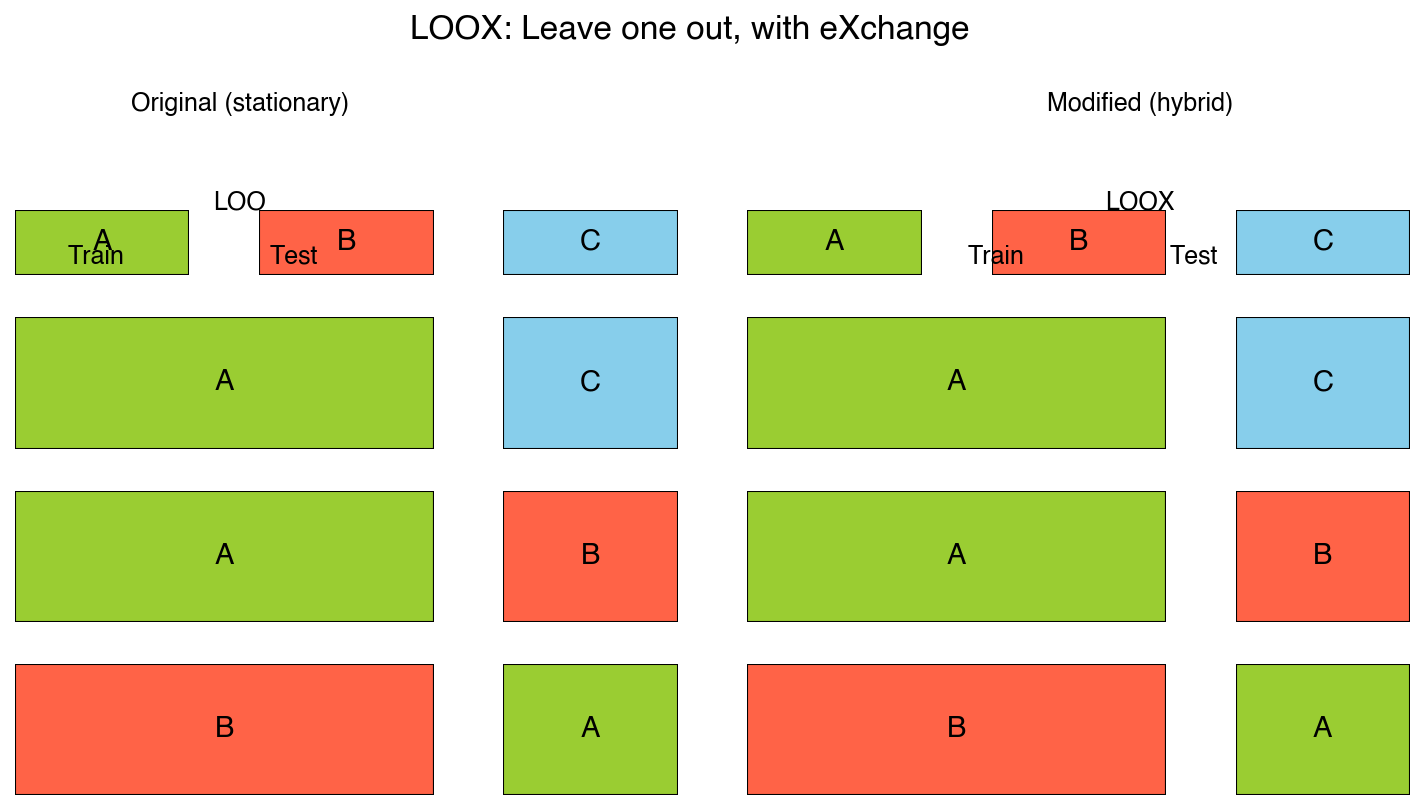

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

# Colors for blocks
colors = {'A': 'yellowgreen', 'B': 'tomato', 'C': 'skyblue'}

# Initialize the figure
fig = plt.figure(figsize=(12, 6), dpi=150)
gs = GridSpec(5, 6, figure=fig, height_ratios=[0.5, 0.5, 1, 1, 1])

# Title texts
fig.text(0.5, 0.95, "LOOX: Leave one out, with eXchange", ha='center', fontsize=16, fontweight='bold')
fig.text(0.25, 0.87, "Original (stationary)", ha='center', fontsize=12)
fig.text(0.75, 0.87, "Modified (hybrid)", ha='center', fontsize=12)

# Draw the original and modified top row blocks
for i, label in enumerate(['A', 'B', 'C']):
    fig.add_subplot(gs[1, i])
    plt.gca().add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=colors[label], edgecolor='black'))
    plt.text(0.5, 0.5, label, ha='center', va='center', fontsize=14, fontweight='bold')
    plt.axis('off')

for i, label in enumerate(['A', 'B', 'C']):
    fig.add_subplot(gs[1, i+3])
    plt.gca().add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=colors[label], edgecolor='black'))
    plt.text(0.5, 0.5, label, ha='center', va='center', fontsize=14, fontweight='bold')
    plt.axis('off')

# Add LOO and LOOX labels
fig.text(0.25, 0.76, "LOO", ha='center', fontsize=12, fontweight='bold')
fig.text(0.75, 0.76, "LOOX", ha='center', fontsize=12, fontweight='bold')

# Table rows for "LOO" (left side)
loo_train = [['A', 'B'], ['A', 'C'], ['B', 'C']]
loo_test = ['C', 'B', 'A']
for row in range(3):
    fig.add_subplot(gs[2+row, 0:2])
    plt.gca().add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=colors[loo_train[row][0]], edgecolor='black'))
    plt.gca().add_patch(patches.Rectangle((1, 0), 1, 1, facecolor=colors[loo_train[row][1]], edgecolor='black'))
    plt.text(0.5, 0.5, loo_train[row][0], ha='center', va='center', fontsize=14, fontweight='normal')
    plt.text(1.5, 0.5, loo_train[row][1], ha='center', va='center', fontsize=14, fontweight='normal')
    plt.axis('off')
    
    fig.add_subplot(gs[2+row, 2])
    plt.gca().add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=colors[loo_test[row]], edgecolor='black'))
    plt.text(0.5, 0.5, loo_test[row], ha='center', va='center', fontsize=14, fontweight='normal')
    plt.axis('off')

# Table rows for "LOOX" (right side)
loox_train = [['A', 'B'], ['A', 'C'], ['B', 'C']]
loox_test = ['C', 'B', 'A']
for row in range(3):
    fig.add_subplot(gs[2+row, 3:5])
    plt.gca().add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=colors[loox_train[row][0]], edgecolor='black'))
    plt.gca().add_patch(patches.Rectangle((1, 0), 1, 1, facecolor=colors[loox_train[row][1]], edgecolor='black'))
    plt.text(0.5, 0.5, loox_train[row][0], ha='center', va='center', fontsize=14, fontweight='bold')  # Bolded for LOOX
    plt.text(1.5, 0.5, loox_train[row][1], ha='center', va='center', fontsize=14, fontweight='bold')  # Bolded for LOOX
    plt.axis('off')
    
    fig.add_subplot(gs[2+row, 5])
    plt.gca().add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=colors[loox_test[row]], edgecolor='black'))
    plt.text(0.5, 0.5, loox_test[row], ha='center', va='center', fontsize=14, fontweight='bold')  # Bolded for LOOX
    plt.axis('off')

# Labels for Train and Test columns
fig.text(0.17, 0.7, "Train", ha='center', fontsize=12, fontweight='bold')
fig.text(0.28, 0.7, "Test", ha='center', fontsize=12, fontweight='bold')
fig.text(0.67, 0.7, "Train", ha='center', fontsize=12, fontweight='bold')
fig.text(0.78, 0.7, "Test", ha='center', fontsize=12, fontweight='bold')

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()
